# DiSummit 2018 - Introduction to text mining 
# Exercises
<img src="XploData_logo.png" width = "40%">
<br>
Powered by [XploData](https://www.xplodata.be/)
<br>
Reinert Roux - Jellert Schaepherders

## Introduction

Text mining is a general term used to indicate the retrieval of information from (large quantities of) text. What can be done by hand (reading text, knowing what it is about, determining keywords, associating it with other texts...) can to some extent also be done by using machine learning algorithms, be it much faster. In this hands-on Python workshop, we will introduce you to some of the basic text mining principles.

In the context of the [HIV Hackathon](https://hivhack.org/), organized by DigitYser in September 2018, we will mine text from multiple PDFs related to HIV. For example, this [publicly available PDF](http://phia.icap.columbia.edu/wp-content/uploads/2017/11/Tanzania_SummarySheet_A4.English.v19.pdf) related to HIV in Tanzania. Although the PDFs contains multiple types of data, the scope of this workshop will be limited to the actual text itself. 
<br>
*Note that text can also be extracted from images using [OCR](https://en.wikipedia.org/wiki/Optical_character_recognition).*

Before we can start with text mining, we need to acquire the text from our PDFs and load it into Python.
Fortunately, multiple Python libraries exist. We will use the popular PyPDF2 package.
For flexibility reasons, we will also introduce the XpdfReader toolkit.

This notebook is the exercise version of the workshop. In this version some code parts are left out. You need to fill those out yourself. Feel free to check the solution version (afterwards).

Places where your input is expected will look like this:

`var = ##your code##`

Make sure to replace all the `#` so that the code can be executed.


## Importing data

In these exercises we assume that we already have a txt version of all our pdf files.
For more information on how to achieve those txt files, look at the solution version of this document.

In [1]:
# Project setup
import os

# change working directory
os.chdir('..')
project_root = os.getcwd()
print(project_root)

D:\Work\01.Internal Projects\03.Data Science\20180627 DiSummit


In [2]:
import chardet

# define input file path
txt_file = os.path.join(project_root, 'output', 'output_txt', 'guess_encoding.txt')

# read file as bytes
with open(txt_file, mode='rb') as byte_file:
    raw_input = byte_file.read()

# guess encoding
encodings = chardet.detect(raw_input)
print(encodings)

{'encoding': 'ISO-8859-2', 'confidence': 0.8312034088608176}


In [3]:
# decode bytes to string
text = raw_input.decode('8859')
# show text sample
print(text[-900:])

tant national and regional HIV-related parameters, including progress toward 90-90-90 goals, and will guide policy and funding priorities. ICAP at Columbia University is implementing the PHIA Project in close collaboration with CDC and other partners. See phia.icap.columbia.edu for more details.
The mark "CDC" is owned by the US Dept. of Health and Human Services and is used with permission. Use of this logo is not an endorsement by HHS or CDC of any particular product, service, or enterprise. This project is supported by the U.S. President's Emergency Plan for AIDS Relief (PEPFAR) through CDC under the terms of cooperative agreement #U2GGH001226. The findings and conclusions in this report are those of the authors and do not necessarily represent the official position of the funding agencies. The results presented should be considered preliminary and they are subject to change.
6




In this notebook, we will continue using the `ISO-8859-1` decoded text.

For more information on supported codecs, visit the python [docs](https://docs.python.org/3/library/codecs.html#standard-encodings).

### Language detection
A human capable of reading is able to distinguish between his mother tongue and a foreign language. We perceive this by reading language specific words, grammatical constructions, context... Language detection in Python is quite straightforward and is performed using the `langdetect` package.

In [4]:
from langdetect import detect

language = detect(text)
print(language)

en


## Data preprocessing
Until this point, you were mainly preparing the data, i.e. converting the pdf to text and analyzing some meta-data.
The next critical step in text mining is preprocessing. This process involves different techniques (for an overview, see [here](https://pdfs.semanticscholar.org/1fa1/1c4de09b86a05062127c68a7662e3ba53251.pdf)), of which we will cover **tokenization, part-of-speech tagging, stop word removal, stemming and lemmatization**.
### Wordclouds and bar charts
To get insights in the contents of a text file, various visualisations are possible. Frequently used visualisations are wordclouds and bar charts. These will therefore be used to demonstrate the different aspects of text mining preprocessing.

*Since we will often repeat the same visualisations during this workshop, we prepared a custom function:*

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

# instantiate wordcloud
wordcloud = WordCloud(  background_color='white',
                        max_words=50,
                        max_font_size=80, 
                        random_state=42,
                        collocations=False)

def gen_wc_barh(tokens, title='Default title', amount=9):
    """
    Generate a horizontal bar graph from the top #amount tokens.
    Generate a wordcloud from the provided tokens.
    Show both vizualizations.
    """
    # count tokens
    ctr = Counter(tokens)
    
    # initialize plt figure
    plt.figure(figsize=(12,9))
    
    # generate barh from counted tokens
    tokens, weights = zip(*ctr.most_common(amount))
    plt.subplot2grid((3, 3), (0, 0))
    plt.barh(tokens, weights)
    plt.ylabel('Tokens')
    plt.xlabel('Count')
    plt.title('Token count bar-graph')
    
    # generate wc from the counted tokens
    wordcloud.generate_from_frequencies(dict(ctr))
    plt.subplot2grid((3, 3), (0, 1), colspan=2)
    plt.imshow(wordcloud, interpolation='nearest')
    plt.axis('off')
    plt.title('Word cloud')

    # general title
    plt.suptitle(title, fontsize=16)
        
    # show both graphs
    plt.show()

To demonstrate the importance of preprocessing, we will generate a visualisation after each preprocessing step, whereafter you can evaluate the effect. For starters, we build our first visual on the *unpreprocessed* text, to get a feeling of what a wordcloud can tell you about the contents of a text file.

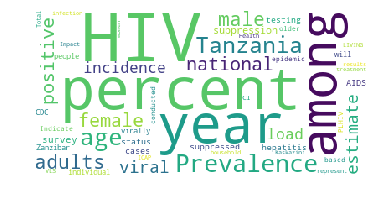

In [6]:
# generate from unprocessed input text
wordcloud.generate_from_text(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Notice how frequent occurring words are displayed in a larger font size. Yet these are not necessarily the most important words (e.g. percent, year, among). Luckily, you can improve this! Let's take it step by step.

### Natural Language Toolkit (NLTK)
One of the core python packages we will use during this workshop is `nltk`.
You can install this package like any other python package (using conda or pip etc...) but this does not install everything. A lot of the functions in this package depend on prebuild corpora and models that need to be downloaded separately. Depending on how you are using this notebook, the downloads migth have already been done. If you get any errors using `nltk` functions, check the error for mentions of missing downloads.

*This notebook uses the following nltk packages:*
 - averaged_perceptron_tagger 
 - maxent_ne_chunker
 - punkt
 - wordnet
 - words
 - stopwords

### Tokenization
[Tokenization]( https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) is the process of cutting the text files in individual *tokens*. These can be words, but also numbers, punctuation marks or symbols. However, don’t you worry about that just yet.

#### Exercise
Use `nltk.sent_tokenize` to split the text into sentences.

Use `nltk.word_tokenize` to split a sentence into tokens.

*Note that both functions take a `str` as input and return a list, so you will need to use a list-comprehension to apply `nltk.word_tokenize` on an individual sentence.*

In [ ]:
import nltk

# get the input text
text = raw_input.decode('8859')

# break text into smaller bits -> tokens
# First, split the text in sentences
sentences = ##your code##
# Then we further split each sentence into tokens
tokenized_sentences = [##your code##]


In [ ]:
# concatenate all the tokenized sentences into a single list
gen_wc_barh([token for sent in tokenized_sentences for token in sent], title='Tokenized text')

As predicted, you can see that the extracted tokens resulted in more than just 'words'. What do you think was used as delimiter (or separator) for splitting the tokens?

### Part-of-Speech tagging
To increase the value of our freshly extracted tokens, we can assign labels/tags to them. As a result, each token is given a grammatical meaning. This process is called [Part-Of-Speech (POS) tagging](https://en.wikipedia.org/wiki/Part-of-speech_tagging). The ‘tagging’ is based on a previously trained model, which we can also call from the `nltk` package. The default tags generated by `nltk` can be found [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

#### Exercise
Use `nltk.pos_tag` to perform POS tagging on the tokens.

This functions expects a list of tokens and returns a list of tuples `(token, tag)`.

*So again, you will have to use a list-comprehension to apply `nltk.pos_tag` on a sentence.*

In [ ]:
# We use the model built into NLTK to assign grammatical meaning to our tokens -> POS tags
tagged_sentences = [##your code##]
print("Example tagged sentence:")
print(tagged_sentences[42])

When visualizing our text, we usually aren't interested in all types of tokens. For our usecase we are interested in discovering the topics of our text, so we are more interested in 'word-like' tokens. Therefore, let's select the appropriate tokens:

In [ ]:
# determine which tokens we want to consider
# shorthand POS tag lists:
adj = ['JJ', 'JJR', 'JJS']
noun = ['NN', 'NNS', 'NNP', 'NNPS']
adverb = ['RB', 'RBR', 'RBS']
verb = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# interesting tokens
tokens = [(token, tag)\
            for sentence in tagged_sentences\
            for (token, tag) in sentence\
            if token.isalpha()\
            and tag in adj + noun + adverb + verb]

# extract the 'token-values' from the tagged sentences
gen_wc_barh([token for (token, tag) in tokens], title='Filtered tokens')

Note that the tagging is not always ‘sure’ about the meaning of a word. Could you determine which (of the) word(s) in the above bar chart has/have multiple tagging possibilities?

#### Exercise
Different textmining applications require different preprocessing.
For example in sentiment analysis we're mostly interested in adjectives.
Or maybe we're analyzing certain verb usages per category etc.

**Apply different filters on the code above to get a different set of tokens.**

### Stop words removal
Spoken languages contain a lot of (small) words that usually don't add extra meaning to a sentence. These words are called stop words. How many stop words do you think are in this paragraph? To better understand the content of a text, you want to filter out those stop words.

In [7]:
from nltk.corpus import stopwords
# filter out the English stopwords
stopwords = stopwords.words('english')
tokens = [(token, tag) for (token,tag) in tokens if token not in stopwords]

# extract the 'token-values' from the filtered tokens 
gen_wc_barh([token for (token, tag) in tokens], title='Stopwords removed')

NameError: name 'tokens' is not defined

Do you see the changes in the wordcloud with and without the removal of stop words? Which words were omitted?

#### Exercise
Check if you guessed correctly which words in the paragraph above are stopwords by filtering them out using the `stopwords` list.

In [ ]:
paragraph = "Spoken languages contain a lot of (small) words that usually don't add extra meaning to a sentence. These words are called stop words. How many stop words do you think are in this paragraph? To better understand the content of a text, you want to filter out those stop words."

# tokenize the paragraph
paragraph_tokenized = ##your code##

# remove the stopwords
paragraph_no_stops = ##your code##

# print the result
print(' '.join([token for (token, tag) in paragraph_no_stops]))

### Stemming
[Stemming](https://en.wikipedia.org/wiki/Stemming) is a preprocessing step whereby inflected words are reduced to their word stem, base or root form. To give an example, the words “computational”, “computers” and “computation” would, according to a predefined algorithm, result in the stem word “comput” after the stemming process. Consequently, words with a similar stem will be grouped together and won’t skew the word count/frequency distribution. However, “comput” isn’t a real word and could obscure the interpretation of the text. Nevertheless, the code is not very complicated as shown below:

#### Exercise
Use the method `stem` of the initialized stemmer to stem all the `tokens`.

It takes a `str` as an input and also returns a `str`.

*Note that `tokens` is a list of tuples `(token, tag)`, so again list-comprehensions are our friend. Make sure you apply the method to the token only, not the whole tuple.*

In [ ]:
from nltk.stem import PorterStemmer

# stem tokens using the Porter Stemmer
stemmer = PorterStemmer()
stemmed_tokens = [##your code##]

gen_wc_barh(stemmed_tokens, title='Stemmed tokens')

*As a side note: stemming could be followed by a stem completion algorithm, which completes the stemmed words (e.g. "comput") to their meaningful counterparts (e.g. "computer"), based on a predefined completion dictionary.*

### Lemmatization
While stemming uses predetermined rules to get to the *stem* version of a word, [lemmatization](https://en.wikipedia.org/wiki/Lemmatisation) is based on a trained model and is aware of word *meanings*. For example: “are” and “be” will remain two different words after stemming, but will be changed into 'is' after the lemmatization process. Still, a well-trained algorithm can distinguish between similar words with different meanings (e.g. 'viral' and 'virally'), so they are not combined during lemmatization.

For our lemmatization we are using the 'wordnet' model. When using this for the first time, you need to **download this model first**  (you can execute the commented code).

#### Exercise
Use the method `lemmatize` of the initialized lemmatizer to lemmatize all the `tokens`.

It takes a `str` as an input and also returns a `str`.

*Note that `tokens` is a list of tuples `(token, tag)`, so again list-comprehensions are our friend. Make sure you apply the method to the token only, not the whole tuple.*


In [ ]:
import nltk.stem.wordnet as wordnet
# nltk.download('wordnet')

# Lemmatize interesting tokens
lemmatizer = wordnet.WordNetLemmatizer()
lemmatized_tokens = [##your code##]
gen_wc_barh(lemmatized_tokens, title='Lemmatized tokens')

What are the main differences between these visuals and the previous ones? Which one is more useful?

### Bag-of-words
So far, what you mainly have been doing, is a so called [bag-of-words analysis](https://en.wikipedia.org/wiki/Bag-of-words_model). This simplified model literally throws all words (or tokens, if you wish) of a document into a ‘bag’ and then looks for the most occurring ones. Now, we will do this for a range of documents.

We will start with reading multiple documents and putting them in a [pandas](https://pandas.pydata.org/) DataFrame.

In [ ]:
import os
import pandas as pd

txt_dir = os.path.join(project_root, 'output', 'medicine_txt')

file_name = []
input_text = []

# read all txt files (one time)
for curr_dir,_,filenames in os.walk(txt_dir):
    for filename in filenames:
        # filter to select only the pdfs that were converted using the 'simple' option
        if filename[:7] == 'simple_':
            # decode using the iso-8859 character set
            with open(os.path.join(curr_dir, filename), 'rt', encoding='8859') as file:
                txt_input = file.read()
                # consider only files with at least 100 characters
                if len(txt_input) > 99:
                    # strip '.txt' from the filename
                    file_name.append(filename[7:-4])
                    input_text.append(txt_input)

# store the documents in a pd.DataFrame
df = pd.DataFrame({'filename':file_name, 'text':input_text})

We now have a small DataFrame containing the filename and text-content of our documents. We can do some of the preprocessing introduced earlier and store the results in extra columns.

*This step can take a few minutes ...*

#### Exercise
Perform preprocessing steps on the `text` column.
Note that now we have a pd.DataFrame containing texts instead of just a variable.
We can apply the `nltk` preprocessing functions on each element of a pd.Series (a DataFrame column) using `Series.apply()`

We want to perform 3 preprocessing steps:
- tokenize the text
- POS-tag the tokens
- filter on POS-tags

*Hint, list-comprehensions can be your friend again!*

In [ ]:
# extract tokens from text
df['tokens'] = df['text'].apply(lambda txt: ##your code##)

# POS-tagging on the tokens
df['POS_tags'] = ##your code##

# split on tags
adj = ['JJ', 'JJR', 'JJS']
noun = ['NN', 'NNS', 'NNP', 'NNPS']
adverb = ['RB', 'RBR', 'RBS']
verb = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# select only tokens that were tagged as 'adjective', 'noun' or 'verb'.
df['i_tokens'] = ##your code##

To get a first feeling of the resulting tokens we can use two collection classes built-in to standard python: `set` and `Counter`.

#### Exercise
For each element in the `i_tokens` column, make a set.

For each element in the `i_tokens` column, make a Counter collection.

*Hint, Object initializer functions like `set` and `Counter` can be passed as a regular function to `pd.Series.apply()`.*

In [ ]:
from collections import Counter

# get a set of unique tokens in our documents
df['set_of_words'] = ##your code##
# print the results
for index,value in df['set_of_words'].items():
    print('Document {0} contains {1} unique words.'.format(index, len(value)))
print()    

# count the tokens using a 'Counter' collection
df['count_of_words'] = ##your code##
# print the top 9 words of each document
for index,value in df['count_of_words'].items():
    print('Document {0} top words are {1}.'.format(index, value.most_common(9)))

#### Document Term Matrix
From the `i_token` column of the DataFrame, one can construct a [document-term-matrix **(DTM)**](https://en.wikipedia.org/wiki/Document-term_matrix).
Simply put, a DTM is just another mathematical representation of multiple bag of word analyses, with rows corresponding to the documents in the corpus and columns corresponding to the terms (tokens/words). The values are the term (word/token) frequencies per document. One can also normalize these frequencies by dividing by the total number of words per document.

With `sklearn`, you can use `vectorizers` to create a DTM to go from text or tokens to a ([sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html)) matrix representing such a DTM.

#### Exercise
Create a second `CountVectorizer` with the same parameters as the `tf_full_vectorizer`. Use this vectorizer to create a DTM from the `i_tokens` instead of the full text.

*Note that the Vectorizer with these parameters expects a `str` as input and not a list of `str`, you can use the `pd.Series.apply()` to convert the tokens to a `str`.*

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Create a document-term-matrix from the full text
tf_full_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf_full = tf_full_vectorizer.fit_transform(df['text'])

# Create a document-term-matrix from the selected tokens only
tf_segm_vectorizer = ##your code##
tf_segm = ##your code##

We can have a look at a small sample of the tf_segm matrix.

Let's also normalize this matrix with the total amount of words in each document.

#### Exercise
Normalize the `tf_segm` matrix by dividing it by the total amount of words in each document.

*Hint, you can pass the optional parameter `axis=1` to the `np.matrix.sum()` function to sum over rows instead of the whole matrix. This will result in a matrix of shape (1,y).*

*Note that multiplication and division of numpy matrices have some interesting syntactic sugar, preventing us from having to write a lot of code. For our usecase we can use a matrix of shape (x,y) and divide it by a matrix of shape (1,y). It will divide every element in the first matrix with its corresponding y in the 2nd matrix.*

In [ ]:
print('DTM')
print(tf_segm[:,:4].todense())
print()

print('Term frequency')
# compute the term-frequency by dividing by total words in the document
term_freq = ##your code##
print(term_freq[:,:4])

#### Term Frequency (TF) vs Term Frequency - Inverse Document Frequency (TF-IDF)
Instead of considering the raw term frequencies per document, one could also account for the frequencies in the corpus. The sparseness of a term is measured by its inverse document frequency. The product of the TF and IDF gives you the TF-IDF. Whichever you use, depends on the purpose.

#### Exercise
Create a `TfidfVectorizer` using the same parameters as in the previous exercise.

Train the model like you did in the previous exercise.

In [ ]:
# Create a Term frequency-inverse document frequency (tf-idf) matrix from the selected tokens
tfidf_vectorizer = ##your code##
tfidf = ##your code##

print('Term frequency - Inverse document frequency')
print(tfidf[:,:4].todense())

Let us compare a sample of the term-frequency matrix with the same sample of the term frequency-inverse document frequency matrix. 

*We will look at a couple of words from the 7th document.*

In [ ]:
tf_df = pd.DataFrame(term_freq, columns=tf_segm_vectorizer.get_feature_names())
tf_df.iloc[7,8:19].T.plot(kind='bar')
plt.title('Term Frequency')

#### Exercise
Make the same visualization for the tfidf matrix.

In [ ]:
tfidf_df = ##your code##
##your code##.plot(kind='bar')
plt.title('Term Frequency - Inverse Document Frequency')

Comparing these two bar charts, you can tell that some of the words had their *weights* shifted. For example, comparing the word **able** with **abnormal**, we can see that **able** loses some significance compared to **abnormal** in the TF-IDF matrix.
This indicates that it's a word that occurs in more documents thus makes it less likely that it's an identifying or unique word in the current document and thus has **less power to differentiate between documents**.

### Named Entity Recognition
After all preprocessing steps, the *real* fun begins. Where POS tagging was limited to tag individual words only, [named entity recognition](https://en.wikipedia.org/wiki/Named-entity_recognition) is able to group multiple tokens into predefined categories, such as person names, locations, organizations, products, time... 
We'll give an example below:

In [ ]:
# discover named entities based on POS tags
chunked_sentences = nltk.ne_chunk_sents(tagged_sentences, binary=True)
# take a 'random' sentence
sentence = list(chunked_sentences)[-4]
print(sentence)
# You can get a more graphical drawing (will show up in a pop-up window)
#sentence.draw()

In the sentence above, you can recognize the found 'Named Entities' by the prefix `(NE`. We can now use the same wordcloud and bar chart visualizations to highlight the most frequent occurring named entities:

In [ ]:
# discover named entities based on POS tags
chunked_sentences = nltk.ne_chunk_sents(tagged_sentences, binary=True)

# filter out everything else
named_entities = [chunk.leaves() for sent in chunked_sentences for chunk in sent if hasattr(chunk, "label") and chunk.label() == "NE"]
NE_tokens = [token for leaves in named_entities for (token, tag) in leaves]

gen_wc_barh(NE_tokens, title='Named Entities')

#### Exercise
Using the documents in the DataFrame, can you give all titles of the documents containing the acronym HIV more than 15 times?

In [8]:
##your code##

## Topic detection & prediction
Instead of doing a simple bag-of-words analysis, let's do something more fancy: topic detection! 

To this end, we will be using the popular [latent Dirichlet allocation model **(LDA)**](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). 
This model can also be used to predict the topics of new, unseen documents.

An LDA model is essentially used to discover topics in documents based on a variety of variables, such as the number of topics, number of documents, probability and distribution of words, identity and weights of the words etc. The math behind the model is mind-boggling (have a look [here]( https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution)). Luckily for us, calling the LDA model in Python is not that hard.

*Note that for the purpose of this workshop we will keep the model simple. As an exercise you can apply more of the  preprocessing techniques we discussed earlier  (notably stemming or lemmatizing) and experiment with the parameters of the model itself.*

We use the two DTMs we computed earlier to train two LDA models:
- one model on the full text without preprocessing
- one model where we've done some minimal preprocessing to get a model built on only verbs, nouns and adjectives.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# init LDA to look for 3 topics, using the DTM of the full text
lda_full = LatentDirichletAllocation(n_components=3, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
# a second model for the segmented DTM
lda_segm = LatentDirichletAllocation(n_components=3, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
# fit the model and transform for results
lda_full_results = lda_full.fit_transform(tf_full)
lda_segm_results = lda_segm.fit_transform(tf_segm)


The two models have now come up with `n=3` topics and calculated which features determine that a document corresponds to a certain topic.

Let's have a look at the models:

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    
print_top_words(lda_full, tf_full_vectorizer.get_feature_names(), 9)
print_top_words(lda_segm, tf_segm_vectorizer.get_feature_names(), 9)

Notice that 'Topic \#0' from `lda_full` looks very similar to 'Topic \#1' from `lda_segm`, so even though we have two different models, trained on slightly different input, they have come up with rather similar topics.

What we printed out here are the top features for each topic, it does not have any meaning beyond that. You can however label these topics yourself or ask a business user to do so based on the top features or some example documents.

We can now use these models on a new document to classify it.

In [ ]:
# read in a new file
txt_file = os.path.join(project_root, 'output', 'output_txt', 'guess_encoding.txt')
with open(txt_file, mode='rt', encoding='8859') as byte_file:
    new_text = byte_file.read()

# transform the new text to a doc-term-matrix
tf_full_new = tf_full_vectorizer.transform([new_text])
tf_segm_new = tf_segm_vectorizer.transform([new_text])
# and transform to discover associated topics
lda_full_new = lda_full.fit_transform(tf_full_new)
lda_segm_new = lda_segm.fit_transform(tf_segm_new)
print(lda_full_new)
print(lda_segm_new)


## Other

Usefull libs:

- re
- gensim
- spaCy
- polyglot
- scikit-learn


Popular NL classifier:
- Naive-Bayes
